# SketchGAN prototype

In [22]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os, os.path
from PIL import Image
from collections import deque
import random
plt.rcParams["axes.grid"] = False

In [23]:
#global vars
std_output_channel=64
std_batch_size=4
gpu_enabled=torch.cuda.is_available()
edge_threshold=0.2
std_sketch_loss=nn.L1Loss()
g_learning_rate=1e-5
d_learning_rate=1e-5
max_num_fake=10
optim_betas = (0.9, 0.999)
GP_lambda=0.5
dtype=torch.cuda.FloatTensor if gpu_enabled else torch.FloatTensor

In [24]:
#preprocessing functions
def LoadDataSet(path)->"grayscale pictures":
    data_transform=T.Compose([
        T.Resize((256,256)),
        T.Grayscale(1),
        T.ToTensor(),
    ])
    dataset = dset.ImageFolder(root=path,transform=data_transform)
    return torch.utils.data.DataLoader(dataset, batch_size=std_batch_size,shuffle=True, num_workers=1)

def LoadTestSet(path):
    res=[]
    for f in os.listdir(path):
        img=Image.open(os.path.join(path,f))
        w,h=img.size
        w=64*round(w/64)
        h=64*round(h/64)
        transform=T.Compose([T.Resize((h,w)),T.Grayscale(1),T.ToTensor()])
        res.append(transform(img).type(dtype))
    return res

In [25]:
#util functions/classes

def ShowImage(inp):
    inp = utils.make_grid(inp)
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def Tensor2Edges(img,mode='Laplacian')->"edges":
    #cv2.Laplacian
    #cv2.Sobel
    #cv2.Canny
    img=img.squeeze(1)
    res=np.uint8(img.data*255)
    for i in range(res.shape[0]):
        if mode=='Canny':
            res[i]=cv2.Canny(res[i],80,150)/255
        elif mode=='Laplacian':
            res[i]=cv2.Laplacian(res[i],cv2.CV_8U)/255
        elif mode=='Sobel':
            res[i]=cv2.Sobel(res[i],cv2.CV_8U,1,1,ksize=5)/255
        else:
            return None
    return torch.tensor(1-res).unsqueeze(1).type(dtype)

def SketchLoss(img,edges)->"loss":
    assert(img.shape==edges.shape)
    return torch.mean(torch.abs(img-edges)).type(dtype) #L1 loss

def ProbLessthan(prob):
    return random.random()<prob

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

def SaveModel(model,path):
    torch.save(model.state_dict(), path)

def LoadModel(model,path):
    res=model().type(dtype)
    res.load_state_dict(torch.load(path))
    return res
    

In [26]:
class UnetGenerator(nn.Module):
    def __init__(self, input_nc=1, output_nc=1, num_downs=6, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        use_bias=False
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [27]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=1, output_nc=1, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        use_bias=False

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [28]:
class Generator_Layer(nn.Module):
    def __init__(self,in_c,out_c,d_relu_layer=nn.ELU,u_relu_layer=nn.ReLU,norm_layer=nn.InstanceNorm2d,mid_layer=None,deepest=False,use_dropout=True):
        super(Generator_Layer, self).__init__()
        down_conv=nn.Conv2d(in_c,out_c,kernel_size=4,stride=2, padding=1)
        if deepest:
            up_convtrans=nn.ConvTranspose2d(out_c,in_c,kernel_size=4,stride=2, padding=1)
            self.net=nn.Sequential(*([d_relu_layer(True),down_conv,norm_layer(out_c)]+[ResnetBlock(out_c,'reflect',norm_layer,use_dropout,False)]*2+[u_relu_layer(True),up_convtrans,norm_layer(in_c)]))
        else:
            up_convtrans=nn.ConvTranspose2d(out_c*2,in_c,kernel_size=4,stride=2, padding=1)
            up_layers=[u_relu_layer(True),up_convtrans,norm_layer(in_c)]
            self.net=nn.Sequential(*([d_relu_layer(True),down_conv,norm_layer(out_c)]+[mid_layer]+up_layers+([nn.Dropout()] if use_dropout else [])))
    def forward(self,x):
        res=self.net(x)
        return torch.cat([x,res], 1)
                                 

class Generator(nn.Module):
    def __init__(self, in_c=1,out_c=1,NGF=64,depth=5):
        super(Generator, self).__init__()
        mid_layers=None
        for i in range(depth):
            inc=8 if depth-i>3 else 2**(depth-i-1)
            outc=8 if depth-i>3 else 2**(depth-i)
            mid_layers=Generator_Layer(NGF*inc,NGF*outc,mid_layer=mid_layers,deepest=(i==0))
        
        self.net=nn.Sequential(
            *([nn.Conv2d(in_c,NGF,3,1,1),nn.BatchNorm2d(NGF),nn.LeakyReLU(0.2,True),
               nn.Conv2d(NGF,NGF,kernel_size=4,stride=2, padding=1,bias=True)]+
              [mid_layers]+
              [nn.ReLU(True),nn.Conv2d(NGF*2,NGF,3,1,1),nn.BatchNorm2d(NGF),nn.ReLU(True),
               nn.ConvTranspose2d(NGF,out_c,kernel_size=4,stride=2, padding=1),nn.Tanh()]))
        
    def forward(self, x):
        return self.net(x)

In [29]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=1, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        use_bias=False

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


In [30]:
#training process
G_path=input("Load Generator:")
D_path=input("Load Discriminator:")
if G_path.strip()=="":
    G=UnetGenerator().type(dtype)
else:
    G=LoadModel(UnetGenerator,G_path.strip())
print(G)
if D_path.strip()=="":
    D=NLayerDiscriminator().type(dtype)
else:
    D=LoadModel(NLayerDiscriminator,D_path.strip())
print(D)
G_opt=optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)
D_opt=optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
GenSet,GroundTruth=LoadDataSet('CUHK_dataset/'),LoadDataSet('Sketch_Set/')

Load Generator:Models/G_Unet
Load Discriminator:Models/D_NL
UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inp

In [31]:
G_path="G_Unet2"
D_path="D_NL_7"

0: D: -0.056040938943624496/-0.15042050182819366 G: -0.2527400255203247 


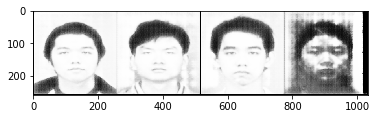

KeyboardInterrupt: 

In [32]:
start=0
num_epochs=3000
print_interval=10
saving_interval=200


one=torch.tensor(1).type(dtype)
mone=-1*one

def GetGradientPenalty(real,fake):
    eps = autograd.Variable(torch.rand(real.shape).type(dtype))
    x_hat= autograd.Variable((eps*real+(1-eps)*fake),requires_grad=True)
    D_res=D(x_hat)
    output=torch.ones(D_res.shape).type(dtype)
    grad=autograd.grad(outputs=D_res, inputs=x_hat,grad_outputs=output,create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad = grad.view(grad.shape[0], -1) 
    return GP_lambda*((grad.norm(2, dim=1) - 1) ** 2).mean()

def GetRealData():
    return next(iter(GroundTruth))[0]

def GetGenData():
    return next(iter(GenSet))[0].type(dtype)

def extract(v):
    return v.data.storage().tolist()

for epoch in range(start,num_epochs):
    D.train()
    for p in D.parameters():
        p.requires_grad = True
    for (data,_) in GroundTruth:
        D.zero_grad()
        d_real_data = data.type(dtype)*2-1
        d_gen_input = GetGenData()*2-1
        d_fake_data = G(d_gen_input).detach()
        d_real_img=torch.cat([d_gen_input,d_real_data])
        d_real_decision = D(d_real_img)
        d_real_error = torch.mean(d_real_decision)
        d_real_error.backward(mone)
        d_fake_img=torch.cat([d_gen_input,d_fake_data])
        d_fake_decision = D(d_fake_img)
        d_fake_error = torch.mean(d_fake_decision)
        d_fake_error.backward(one)
        GP = GetGradientPenalty(d_real_data,d_fake_data)
        GP.backward()
        D_opt.step()
        
    G.train()
    for p in D.parameters():
        p.requires_grad = False 
    for data,_ in GenSet:
        G.zero_grad()
        gen_input = data.type(dtype)*2-1
        g_fake_data = G(gen_input)
        dg_fake_decision = D(torch.cat([gen_input,g_fake_data]))
        g_img=(g_fake_data+1)/2
        g_error = torch.mean(dg_fake_decision)-0.5*SketchLoss(g_img,Tensor2Edges(g_img))-0.5*torch.mean(torch.abs(g_img-data.type(dtype)))
        g_error.backward(mone)
        G_opt.step()
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s " % (epoch,extract(d_real_error)[0],extract(d_fake_error)[0],extract(g_error)[0]))
        G.eval()
        with torch.no_grad():
            test_sample=GetGenData()
            patches=test_sample*2-1
            G_res=G(patches)
            G_tensor=(G_res.detach()+1)/2
            ShowImage(G_tensor.cpu())
    if epoch>=saving_interval and epoch % saving_interval == 0:
        if G_path.strip()!="":
            SaveModel(G,G_path.strip()+'_'+str(epoch))
            print("Saved G at epoch",epoch)
        if D_path.strip()!="":
            SaveModel(D,D_path.strip()+'_'+str(epoch))
            print("Saved D at epoch",epoch)


In [19]:
if G_path.strip()!="":
    SaveModel(G,G_path.strip()+'_'+str(epoch))
    print("Saved G at epoch",epoch)
if D_path.strip()!="":
    SaveModel(D,D_path.strip()+'_'+str(epoch))
    print("Saved D at epoch",epoch)

Saved G at epoch 234
Saved D at epoch 234


In [20]:
TestSet=LoadTestSet('TestSamples')

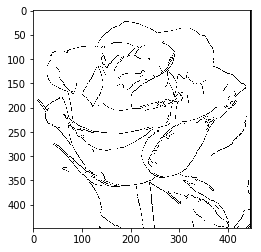

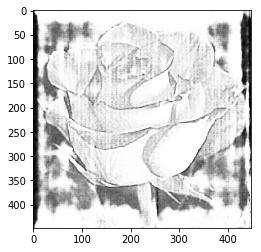

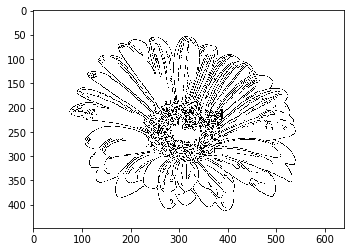

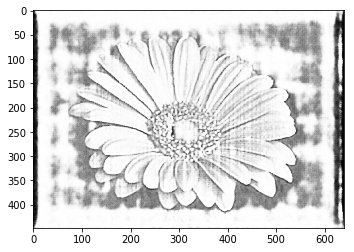

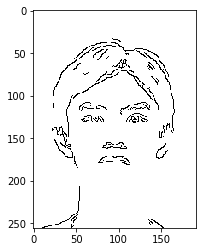

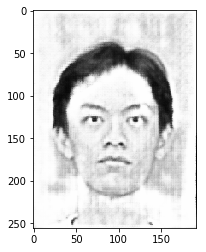

In [21]:
for i in TestSet:
    with torch.no_grad():
        testdata=i.unsqueeze(0).type(dtype)
        patches=testdata*2-1
        G_res=G(patches)
        G_tensor=(G_res.detach()+1)/2
        ShowImage(Tensor2Edges(testdata,"Canny").cpu())
        ShowImage(G_tensor.cpu())